In [1]:
import sys
import time
import argparse
import json
import numpy as np
import pandas as pd
# not compatible with pandas 1.1.0
# pip3 install --user -U pandas==1.0.5
# see https://github.com/limix/pandas-plink/issues/18
from pandas_plink import read_plink

from pprint import pprint

In [2]:
def BDF(prefix):
    (bim, fam, bed) = read_plink(prefix, verbose=True)
    bdf = pd.DataFrame(bed.compute().astype('int8')).join(bim[['snp']]).set_index('snp').append(fam.trait.astype('int8')).transpose()
    bdf.index.name = 'sampleId'
    bdf['trait'] = bdf.trait - 1
    return bdf

In [3]:
def PredictTree(sampleId, sample, treeId, tree, depth, res):
    
    size = tree['size']
    cCase = tree['classCounts'][0]
    pCase = cCase/size
    splitVar = 'NA'
    splitPoint= 'NA'
    gt = -1
    nextNode = 'NA'
    
    # Check if node is not a leaf
    if 'splitVar' in tree:
        splitVar = tree['splitVar'].replace("_", ":")
        splitPoint = int(tree['splitPoint'])
        
        # Check for allele order in the variable names
        if splitVar not in sample.index:
            x = splitVar.split(':')
            x[2], x[3] = x[3], x[2]
            splitVar = ':'.join(x)
        
        # If the variable is not found in the target data
        if splitVar not in sample.index:
            print("ERROR")
            exit()
            
        gt = int(sample[splitVar])
        
        nextNode = 'left'
        if(gt > splitPoint):
            nextNode = 'right'
    
    # Add prediction to the list
    res.append({'sampleId':sampleId, 'treeId':treeId, 'depth':depth, 'size':size, 
                'pCase':pCase, 'splitVar':splitVar, 'splitPoint':splitPoint, 
                'gt':gt, 'nextNode':nextNode, 'pheno':sample['trait']})
    
    if 'splitVar' in tree:
        PredictTree(sampleId, sample, treeId, tree[nextNode], depth+1, res)

In [4]:
def PredictForest(forest, sampleId, sample, res):
    for treeId, tree in enumerate(forest):
        PredictTree(sampleId, sample, treeId, tree['rootNode'], 0, res)

In [5]:
def PredictTarget(forest, bdf):
    res = list()
    
    cnt=0
    for sampleId in bdf.index:
        sample = bdf.loc[sampleId]
        PredictForest(forest, sampleId, sample, res)
        cnt += 1
        if(cnt%10 == 9):
            print(cnt)
    
    pdf = pd.DataFrame(res).set_index('sampleId')
    
    return pdf

In [6]:
def Algo0(pdf):
    pred = pdf.loc[pdf['splitVar'] == 'NA'].groupby(['sampleId']).mean()[['pCase','pheno']]
    return pred

In [7]:
def Algo1(pdf, depth):
    return pdf.loc[pdf['depth'] == depth].groupby(['sampleId']).mean()[['pCase','pheno']]

In [8]:
def Algo2(pdf, bdf):
    pdf = pdf.join(pdf.groupby(['sampleId']).sum()[['size']].rename(columns={'size':'totalSize'}))
    pdf['weight'] = pdf['size']/pdf.totalSize
    pdf['wpCase'] = pdf['weight']*pdf.pCase
    return pdf.groupby(['sampleId']).sum()[['wpCase']].join(bdf[['trait']])

# Simulation

In [51]:
bdf = BDF('YCC-0-BD')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 15.95it/s]


In [54]:
x = bdf.replace(2, 1).sum()

In [70]:
x.sort_values().head(260).tail(30)

snp
1:222280834:A:G     1503
16:59804936:C:T     1503
6:27962384:C:T      1503
12:54190733:G:A     1503
trait               1503
3:56949707:A:C      1503
3:56812159:C:T      1503
3:180601807:G:A     1503
14:58404103:C:T     1503
8:239875:T:G        1503
3:56952900:G:A      1503
8:80488252:A:C      1503
12:28147960:C:T     1503
7:107706895:C:T     1503
12:47093014:G:A     1503
3:126792822:A:G     1503
3:35717275:A:G      1503
17:65612092:A:G     1503
19:7635689:T:C      1781
8:12957475:T:C      1862
11:35331642:G:A     2000
8:32169540:C:T      2020
10:126056539:G:A    2041
11:107047996:C:T    2105
3:193668899:C:T     2109
1:159925431:C:T     2132
17:17326363:A:G     2161
17:72466219:A:G     2202
2:226148202:G:A     2242
9:79425692:A:G      2274
dtype: int64

In [72]:
bdf.groupby(['19:7635689:T:C']).count()

snp,1:779322:G:A,1:1003629:C:T,1:1211292:T:C,1:1812688:G:A,1:2069681:T:C,1:2186220:T:C,1:2223258:T:C,1:2280423:A:C,1:2281726:C:A,1:2299627:C:T,...,22:50675962:A:G,22:50859049:C:T,22:50959608:T:C,22:51017353:C:T,22:51063477:C:T,22:51104680:A:G,22:51140316:T:C,22:51175626:G:A,trait,p1
19:7635689:T:C,,,,,,,,,,,,,,,,,,,,,
0,2086,2086,2086,2086,2086,2086,2086,2086,2086,2086,...,2086,2086,2086,2086,2086,2086,2086,2086,2086,2086
1,1148,1148,1148,1148,1148,1148,1148,1148,1148,1148,...,1148,1148,1148,1148,1148,1148,1148,1148,1148,1148
2,633,633,633,633,633,633,633,633,633,633,...,633,633,633,633,633,633,633,633,633,633


In [73]:
bdf['p1'] = 0
bdf.loc[bdf['19:7635689:T:C'] > 0, 'p1'] = 1

In [74]:
bdf.groupby(['p1']).count()

snp,1:779322:G:A,1:1003629:C:T,1:1211292:T:C,1:1812688:G:A,1:2069681:T:C,1:2186220:T:C,1:2223258:T:C,1:2280423:A:C,1:2281726:C:A,1:2299627:C:T,...,22:50672154:A:G,22:50675962:A:G,22:50859049:C:T,22:50959608:T:C,22:51017353:C:T,22:51063477:C:T,22:51104680:A:G,22:51140316:T:C,22:51175626:G:A,trait
p1,,,,,,,,,,,,,,,,,,,,,
0,2086,2086,2086,2086,2086,2086,2086,2086,2086,2086,...,2086,2086,2086,2086,2086,2086,2086,2086,2086,2086
1,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781,...,1781,1781,1781,1781,1781,1781,1781,1781,1781,1781


In [84]:
bdf['x3'] = bdf['17:65612092:A:G'] + bdf['1:222280834:A:G'] + bdf['8:12957475:T:C']

In [85]:
bdf.x3.describe()

count    3867.000000
mean        2.188001
std         1.517472
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         4.000000
Name: x3, dtype: float64

In [87]:
bdf['p2'] = 0
bdf.loc[bdf['x3'] > 2, 'p2'] = 1
bdf.groupby(['p2']).count()

snp,1:779322:G:A,1:1003629:C:T,1:1211292:T:C,1:1812688:G:A,1:2069681:T:C,1:2186220:T:C,1:2223258:T:C,1:2280423:A:C,1:2281726:C:A,1:2299627:C:T,...,22:50859049:C:T,22:50959608:T:C,22:51017353:C:T,22:51063477:C:T,22:51104680:A:G,22:51140316:T:C,22:51175626:G:A,trait,p1,x3
p2,,,,,,,,,,,,,,,,,,,,,
0,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364,...,2364,2364,2364,2364,2364,2364,2364,2364,2364,2364
1,1503,1503,1503,1503,1503,1503,1503,1503,1503,1503,...,1503,1503,1503,1503,1503,1503,1503,1503,1503,1503


In [91]:
bdf

snp,1:779322:G:A,1:1003629:C:T,1:1211292:T:C,1:1812688:G:A,1:2069681:T:C,1:2186220:T:C,1:2223258:T:C,1:2280423:A:C,1:2281726:C:A,1:2299627:C:T,...,22:50959608:T:C,22:51017353:C:T,22:51063477:C:T,22:51104680:A:G,22:51140316:T:C,22:51175626:G:A,trait,p1,x3,p2
sampleId,,,,,,,,,,,,,,,,,,,,,
0,2,2,2,1,2,2,2,2,1,1,...,2,2,2,1,1,1,0,1,1,0
1,2,1,2,0,2,2,2,2,1,1,...,0,2,2,2,0,2,0,1,1,0
2,2,1,2,1,2,2,2,2,1,0,...,2,2,2,0,2,2,0,1,1,0
3,2,2,2,1,2,2,1,2,2,1,...,0,2,2,0,2,2,0,1,0,0
4,2,2,2,0,2,2,2,1,2,1,...,1,2,2,1,1,2,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3862,2,0,2,1,2,2,2,2,1,1,...,0,2,2,1,2,2,1,0,4,1
3863,1,1,2,1,2,2,2,2,1,0,...,1,2,2,0,2,2,1,0,4,1
3864,1,1,2,1,2,2,2,1,2,1,...,1,2,2,1,2,2,1,0,4,1


In [94]:
bdf[['p1','p2']].to_csv('simPheno.csv')

In [109]:
bdf = BDF('p1')
bdf = bdf.sample(n=200, axis='index')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 17.70it/s]


In [100]:
with open('p1.json', 'r') as json_file:
    rfModel = json.load(json_file)
    forest=rfModel['trees']

In [110]:
ydf = PredictTarget(forest, bdf)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199


In [111]:
ydf.to_csv('p1.pred.csv')

In [112]:
# bdf = BDF('XCC-0-BD')
# bdf = bdf.sample(n=1, axis='index')

# xdf = PredictTarget(forest, bdf)

In [113]:
ydf.head(20)

,treeId,depth,size,pCase,splitVar,splitPoint,gt,nextNode,pheno
sampleId,,,,,,,,,
665,0,0,3867,0.545384,3:193668899:C:T,0,0,left,1
665,0,1,1863,0.403113,19:7635689:T:C,1,2,right,1
665,0,2,389,1.000000,NA,NA,-1,NA,1
665,1,0,3867,0.546418,8:12957475:T:C,0,1,right,1
665,1,1,1742,0.247991,3:61757206:T:G,1,2,right,1
665,1,2,64,0.562500,12:129029358:G:A,0,2,right,1
665,1,3,24,0.166667,14:98118378:G:C,1,0,left,1
665,1,4,20,0.000000,NA,NA,-1,NA,1
665,2,0,3867,0.544350,1:159925431:C:T,0,2,right,1


In [114]:
pred = Algo0(ydf)
pred

,pCase,pheno
sampleId,,
5,0.387,1.0
33,0.697,1.0
47,0.683,1.0
48,0.412,1.0
50,0.405,0.0
...,...,...
3807,0.315,0.0
3808,0.331,0.0
3838,0.345,0.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

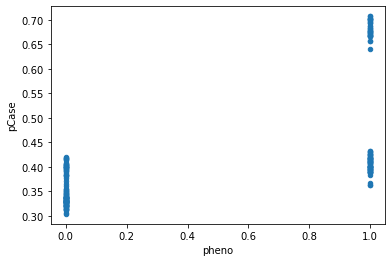

In [115]:
pred.plot.scatter(x='pheno', y='pCase')

In [116]:
pred = Algo1(ydf, 3)
pred

,pCase,pheno
sampleId,,
5,0.427740,1.0
33,0.478836,1.0
47,0.492998,1.0
48,0.404320,1.0
50,0.378069,0.0
...,...,...
3807,0.826126,0.0
3808,0.831041,0.0
3838,0.796688,0.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

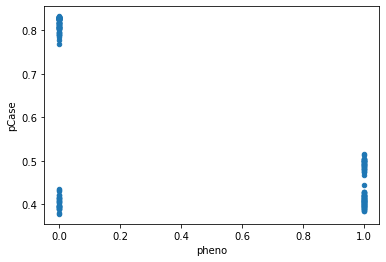

In [117]:
pred.plot.scatter(x='pheno', y='pCase')

In [118]:
pred = Algo2(ydf, bdf)
pred

,wpCase,trait
sampleId,,
5,0.475635,1
33,0.476690,1
47,0.468440,1
48,0.441020,1
50,0.443021,0
...,...,...
3807,0.766719,0
3808,0.770739,0
3838,0.755118,0


<AxesSubplot:xlabel='trait', ylabel='wpCase'>

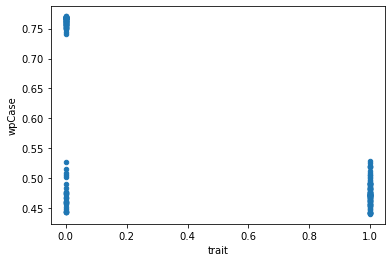

In [119]:
pred.plot.scatter(x='trait', y='wpCase')

In [120]:
bdf = BDF('p2')
bdf = bdf.sample(n=200, axis='index')

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 14.46it/s]


In [121]:
with open('p2.json', 'r') as json_file:
    rfModel = json.load(json_file)
    forest=rfModel['trees']

In [122]:
ydf = PredictTarget(forest, bdf)

9
19
29
39
49
59
69
79
89
99
109
119
129
139
149
159
169
179
189
199


In [123]:
ydf.to_csv('p2.pred.csv')

In [124]:
# bdf = BDF('XCC-0-BD')
# bdf = bdf.sample(n=1, axis='index')

# xdf = PredictTarget(forest, bdf)

In [125]:
ydf.head(20)

,treeId,depth,size,pCase,splitVar,splitPoint,gt,nextNode,pheno
sampleId,,,,,,,,,
348,0,0,3867,0.615723,19:7635689:T:C,0,2,right,0
348,0,1,1770,1.000000,NA,NA,-1,NA,0
348,1,0,3867,0.608223,22:33084511:C:A,0,2,right,0
348,1,1,225,1.000000,NA,NA,-1,NA,0
348,2,0,3867,0.606155,8:32169540:C:T,0,1,right,0
348,2,1,1272,1.000000,NA,NA,-1,NA,0
348,3,0,3867,0.609516,15:93585975:T:G,0,2,right,0
348,3,1,293,1.000000,NA,NA,-1,NA,0
348,4,0,3867,0.607189,8:1184046:G:A,0,2,right,0


In [126]:
pred = Algo0(ydf)
pred

,pCase,pheno
sampleId,,
28,0.983,0.0
81,0.985,0.0
90,0.977,0.0
99,0.987,0.0
119,0.985,0.0
...,...,...
3705,0.613,1.0
3712,0.598,1.0
3739,0.601,1.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

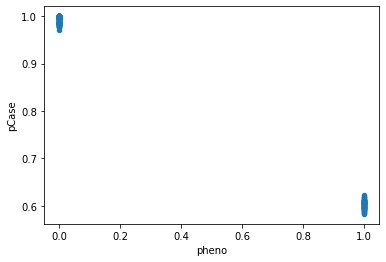

In [127]:
pred.plot.scatter(x='pheno', y='pCase')

In [128]:
pred = Algo1(ydf, 3)
pred

,pCase,pheno
sampleId,,
28,0.859879,0.0
81,0.914857,0.0
90,0.832581,0.0
99,0.922717,0.0
119,0.925915,0.0
...,...,...
3705,0.191499,1.0
3712,0.217515,1.0
3739,0.208355,1.0


<AxesSubplot:xlabel='pheno', ylabel='pCase'>

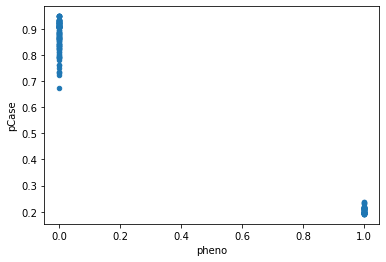

In [129]:
pred.plot.scatter(x='pheno', y='pCase')

In [130]:
pred = Algo2(ydf, bdf)
pred

,wpCase,trait
sampleId,,
28,0.664505,0
81,0.676161,0
90,0.652114,0
99,0.699736,0
119,0.684925,0
...,...,...
3705,0.292979,1
3712,0.308744,1
3739,0.301862,1


<AxesSubplot:xlabel='trait', ylabel='wpCase'>

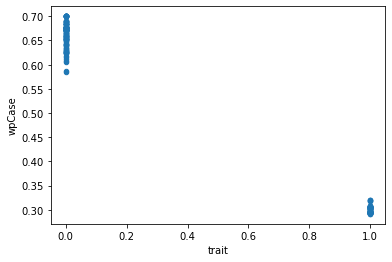

In [131]:
pred.plot.scatter(x='trait', y='wpCase')